<a href="https://colab.research.google.com/github/hajime-8123/AI-Application-repository/blob/main/week11_lab_continuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
url = 'https://raw.githubusercontent.com/NVDLI/LDL/main/pt_framework/utilities.py'
r = requests.get(url)

with open('utilites.py', 'w') as f:
  f.write(r.text)

In [ ]:
pip install python3-utilities

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utilites import train_model

# Your code goes here


device = torch.device("cuda:()" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCHSIZE = 16

TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = '/content/book_store_sales.csv'

def readfile(file_name):
  file = open(file_name, 'r', encoding='utf-8')
  next(file)
  data =[]
  for line in (file):
    values = line.split(',')
    data.append(float(values[1]))
  file.close()
  return np.array(data, dtype=np.float128)


#Read data and split up into train and test data
sales= readfile(FILE_NAME)
months = len(sales)
split= int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]

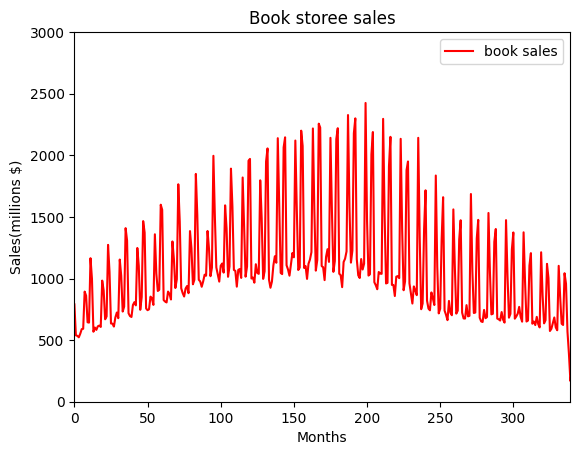

In [ ]:
x = range(len(sales))
plt.plot(x, sales, 'r-', label = 'book sales')
plt.title('Book storee sales')
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales(millions $)')
plt.legend()
plt.show()

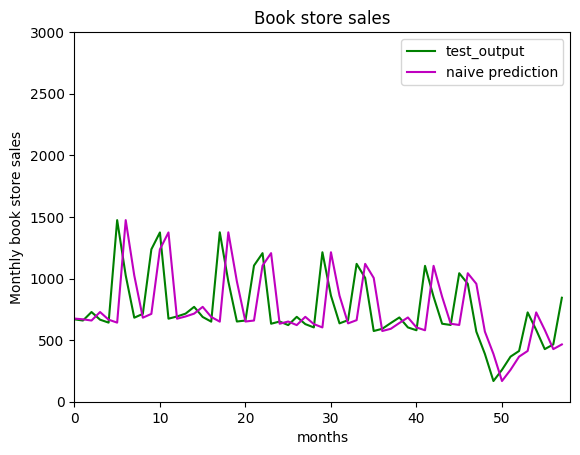

In [ ]:
# Plot naive prediction
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label = 'test_output')
plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()

In [ ]:
#Standardize train and test data
# Use only training seasons to compute mean and stddev

mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/stddev

In [ ]:
# Create train example

train_months = len(train_sales)
train_X = np.zeros((train_months - MIN, train_months - 1, 1), dtype=np.float32)
train_y = np.zeros((train_months - MIN, 1), dtype=np.float32)

for i in range(0, train_months - MIN):
    train_X[i, -(i + MIN):, 0] = train_sales_std[0:i + MIN]
    train_y[i, 0] = train_sales_std[i + MIN]

# Create test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months - MIN, test_months - 1, 1), dtype=np.float32)  # Remove the extra comma here
test_y = np.zeros((test_months - MIN, 1), dtype=np.float32)

for i in range(0, test_months - MIN):
    test_X[i, -(i + MIN):, 0] = test_sales_std[0:i + MIN]
    test_y[i, 0] = test_sales_std[i + MIN]

# Rest of your code remains the same.


  # Create Dataset objects.
trainset=TensorDataset (torch.from_numpy (train_X).clone(), torch.from_numpy(train_y))
testset=TensorDataset (torch.from_numpy(test_X).clone(), torch.from_numpy(test_y))


# Custom layer that retrieves only last time step from RNN output.
class LastTimestep(nn. Module):
  def forward(self, inputs):
    return inputs [1] [0]
# Create RNN model
model=nn.Sequential(nn.RNN (1, 128, nonlinearity='relu', batch_first=True),
                    LastTimestep(),
                    nn.Linear (128, 1))

# Loss function and optimizer.
optimizer=torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()
# Train model.

BATCH_SIZE = 32  # You can choose an appropriate batch size

# Now you can use BATCH_SIZE in your train_model function
train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset, optimizer, loss_function, 'mae')

Epoch 1/100 loss: 1.0438 - mae: 0.6664 - val_loss: 1.0374 - val_mae: 0.8211
Epoch 2/100 loss: 0.8651 - mae: 0.6482 - val_loss: 0.9773 - val_mae: 0.8028
Epoch 3/100 loss: 0.8220 - mae: 0.6191 - val_loss: 0.8123 - val_mae: 0.7366
Epoch 4/100 loss: 0.7778 - mae: 0.5868 - val_loss: 0.8096 - val_mae: 0.7292
Epoch 5/100 loss: 0.5705 - mae: 0.5441 - val_loss: 0.5742 - val_mae: 0.5748
Epoch 6/100 loss: 0.5553 - mae: 0.5055 - val_loss: 0.3659 - val_mae: 0.4788
Epoch 7/100 loss: 0.4847 - mae: 0.4702 - val_loss: 0.3658 - val_mae: 0.3743
Epoch 8/100 loss: 0.5280 - mae: 0.5181 - val_loss: 0.2668 - val_mae: 0.3876
Epoch 9/100 loss: 0.4964 - mae: 0.4775 - val_loss: 0.4131 - val_mae: 0.5172
Epoch 10/100 loss: 0.4521 - mae: 0.4701 - val_loss: 0.2523 - val_mae: 0.3726
Epoch 11/100 loss: 0.4551 - mae: 0.4488 - val_loss: 0.2841 - val_mae: 0.3565
Epoch 12/100 loss: 0.4246 - mae: 0.4448 - val_loss: 0.3367 - val_mae: 0.4429
Epoch 13/100 loss: 0.4082 - mae: 0.4487 - val_loss: 0.2461 - val_mae: 0.3573
Epoch 14

[0.08812425575322574, 0.16590887308120728]

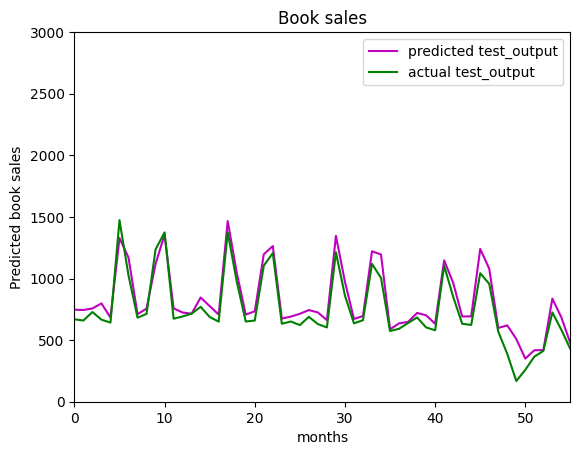

In [39]:
# Use trained model to predict the test data

inputs = torch.from_numpy(test_X)
inputs = inputs.to(device)
outputs = model(inputs)
predicted_test = outputs.cpu().detach().numpy()

# De-standardize output

predicted_test = np.reshape(predicted_test,(len(predicted_test)))
predicted_test = predicted_test * stddev + mean

# Plot test prediction
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-', label='predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):], 'g-', label ='actual test_output')
plt.title('Book sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()